In [12]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [13]:
def smape(pred, true):
    return 200 * np.sum(np.abs(true - pred) / (np.abs(true) + np.abs(pred))) / len(true)

In [14]:
def transf(x: int)-> int:
    #change 1p 
    """ 
    This function performs normalization on the data
    
    Arguments
    ----------
    x: int
        the integer data 

    Returned Values
    ----------
    x: int
        the normalized data
        
    """ 
    return np.log1p(x)
          
def itransf(x: int)-> int:
    """ 
    This function performs inverse normalization on the data
    
    Arguments
    ----------
    x: int
        the normalized data

    Returned Values
    ----------
    x: int
        original data (unnormalized data)
        
    """ 
    return np.expm1(x)

def standardscaler(x: int)-> int:
    """ 
    This function performs standardization on the data i.e subtracting by mean and divinding by standard deviation
    
    Arguments
    ----------
    x: int
        the integer data 

    Returned Values
    ----------
    x: int
        the normalized data
        
    """

    return (x-np.mean(x))/np.std(x)

def inverse_standardscaler(x: int)-> int:
    """ 
    This function performs inverse standardization on the data i.e multiplying by standard deviation and adding the mean 
    
    Arguments
    ----------
    x: int
        the integer data 

    Returned Values
    ----------
    x: int
        the normalized data
        
    """

    return (x*np.std(x))+np.mean(x)

In [15]:
def output_h(temp_results: pd.DataFrame, h: int, n_test:int, horizons: int)-> pd.DataFrame:
    """
    This function processes the 'temp_results' DataFrame, which contains predictions for h weeks ahead for each iteration and organizes the data into a single column for each horizon.

    Arguments
    ----------
    temp_results : pd.DataFrame
        the dataframe that has h weeks ahead prediction for each window
    h : int
        the current horizon value e.g 1, 2, 3, ... , or 6 for COVID-19 case
    n_test : int
        the size of testing set
    horizons: int
        the total number of horizons e.g 6 in the COVID-19 case

    Returned Values
    ----------
    df_results_python : pd.DataFrame
        Dataframe for each horizon.  

    """ 
    n_iter = n_test
    df_results = []
    if h==1:
        for i in range(int(n_iter)):
            window = i + 1
            current_results = temp_results[['window_'+str(window)]].dropna()
            current_results = current_results.rename(columns={'window_'+str(window): "h="+str(h)})
            df_results.append(pd.DataFrame(current_results.iloc[0]).transpose())
    if h>1:
        for i in range(int(h-1)):
            window = i + 1
            current_results = temp_results[['window_'+str(window)]].dropna()
            current_results = current_results.rename(columns={'window_'+str(window): "h="+str(h)})
            current_results.iloc[0,0] = np.nan
            df_results.append(pd.DataFrame(current_results.iloc[0]).transpose())

        for i in range(int(n_iter-(h-1))):            
            window = i + 1
            current_results = temp_results[['window_'+str(window)]].dropna()
            current_results = current_results.rename(columns={'window_'+str(window): "h="+str(h)})
                
            if (i + horizons) > n_test:
                current_results = current_results.iloc[:n_test - (i + horizons)]
            df_results.append(pd.DataFrame(current_results.iloc[int(h-1)]).transpose())
        
    df_results_python = pd.concat(df_results,axis=0)
    
    return df_results_python

In [16]:
def predict_table(n_test, temp_results,horizons)-> pd.DataFrame:
    """
    A function that iterates through each horizon and combines the predictions for each horizon into a final DataFrame that has 'h' columns for each week.

    Arguments
    ----------
    n_test : int
        the size of testing set
    temp_results : pd.DataFrame
        the dataframe that has 'horizons' weeks ahead prediction for each iteration
    horizons: int
        the total number of horizons e.g 6 in the COVID-19 case
    
    Returned Values
    ----------
    df_final_forecast : pd.DataFrame
        DataFrame with 'horizons' columns presenting the 'horizons' weeks ahead prediction for each week.

    """ 
    df_final_forecast = pd.DataFrame()
    for h in range(1, horizons+1):
        df_current = output_h(temp_results, h, n_test,horizons)
        df_final_forecast = pd.concat([df_final_forecast, df_current], axis=1)
        
    return df_final_forecast

In [17]:
def smape_results(df_final_forecast: pd.DataFrame ,y: str, file_name:str)-> pd.DataFrame:
    """ 
    This function calculates the sMAPE score using the sMAPE definition between the original data and the inverse normalized 
    predictions for each horizon
    
    Arguments
    ----------
    df_final_forecast: pd.DataFrame
        DataFrame containing predictions for each week
    y : str
        the target variable
    file_name : str
        filename to read the data

    Returned Values
    ----------
    df_results : pd.DataFrame
        DataFrame with SMAPE scores for each horizon and the average SMAPE score.
        
    """ 
    df_US = pd.read_csv(file_name)
    df_US.index = pd.to_datetime(df_US['date'])
    df_US = df_US.drop(columns=['date'])
    h_level = df_final_forecast.columns.to_list()
    eval = []
    for cols in h_level:
        y_true = df_US.loc[df_final_forecast.index][y]
        y_pred = df_final_forecast[cols]
        
        # plt.figure(figsize=(10, 6))
        # plt.plot(y_true, label='True')
        # plt.plot(y_pred, label='Pred')
        # plt.xlabel('Date')
        # plt.title('sMAPE ' + str(cols))
        # plt.legend()
        # plt.show()
        
        y_pred = y_pred.dropna()
        y_true = y_true.loc[y_pred.index]

        value = smape(y_true, y_pred)
        eval.append(value)
    print(y_pred.shape, y_true.shape)
    eval.append(np.mean(eval))
    df_results = pd.DataFrame(eval, columns=[str(y)])
    h_level.append('Average')
    df_results.index = h_level
    return df_results

In [18]:
def mae_results(df_final_forecast: pd.DataFrame ,y: str, file_name:str)-> pd.DataFrame:
    """ 
    This function calculates the MAE score using the MAE definition between the original data and the inverse normalized 
    predictions for each horizon
    
    Arguments
    ----------
    df_final_forecast: pd.DataFrame
        DataFrame containing predictions for each week
    y : str
        the target variable
    file_name : str
        filename to read the data

    Returned Values
    ----------
    df_results : pd.DataFrame
        DataFrame with MAE scores for each horizon and the average MAE score.
        
    """ 
    df_US = pd.read_csv(file_name)
    df_US.index = pd.to_datetime(df_US['date'])
    df_US = df_US.drop(columns=['date'])
    h_level = df_final_forecast.columns.to_list()
    eval = []
    for cols in h_level:
        y_true = df_US.loc[df_final_forecast.index][y]
        y_pred = df_final_forecast[cols]
        # plt.figure(figsize=(10, 6))
        # plt.plot(df_US[y], label='True')
        # plt.plot(df_pred[cols], "-o", label='Predicted')
        # plt.xlabel('Date')
        # plt.ylabel('Number of Deaths')
        # plt.title('MAE')
        # plt.legend()
        # plt.show()
        value = mae(y_true, y_pred)
        eval.append(value)
    eval.append(np.mean(eval))
    df_results = pd.DataFrame(eval, columns=[str(y)])
    h_level.append('Average')
    df_results.index = h_level
    return df_results

In [19]:
def normmae_results(df_final_forecast: pd.DataFrame ,y: str, file_name:str)-> pd.DataFrame:
    """ 
    This function calculates the MAE score using the MAE definition between the normalized data and the predictions for each horizon
    
    Arguments
    ----------
    df_final_forecast: pd.DataFrame
        DataFrame containing predictions for each week
    y : str
        the target variable
    file_name : str
        filename to read the data

    Returned Values
    ----------
    df_results : pd.DataFrame
        DataFrame with MAE scores for each horizon and the average MAE score.
        
    """ 
    df_US = pd.read_csv(file_name)
    df_US.index = pd.to_datetime(df_US['date'])
    df_US = df_US.drop(columns=['date'])
    h_level = df_final_forecast.columns.to_list()
    eval = []

    df_US_transf = pd.DataFrame()
    for col in df_US.columns:
        df_US_transf[col] = df_US[col].apply(lambda x: transf(x))

    for cols in h_level:
        y_true = df_US.loc[df_final_forecast.index][y]
        y_pred = df_final_forecast[cols]
        y_true = standardscaler(y_true) #to get results for normalized data
        y_pred = standardscaler(y_pred)
        # plt.figure(figsize=(10, 6))
        # plt.plot(df_US_transf[y], label='True')
        # plt.plot(df_final_forecast[cols], "-o", label='Predicted')
        # plt.xlabel('Date')
        # plt.ylabel('Number of Deaths')
        # plt.title('normMAE')
        # plt.legend()
        # plt.show()
        value = mae(y_true, y_pred)
        eval.append(value)
    eval.append(np.mean(eval))
    df_results = pd.DataFrame(eval, columns=[str(y)])
    h_level.append('Average')
    df_results.index = h_level

    return df_results

In [20]:
def run_model(n_train: int, n_test: int, y: str,  horizons: int, file_name: str, m: int, p: int, d: int,
                        q: int, ps: int, ds:int, qs: int, trend: str)-> pd.DataFrame:
    """
    This function uses the SARIMAX model from statsmodels. It predicts 'y' by using 'x' as exogenous variables. 
    Each exogenous variable is shifted by lags. It trains the model once and performs dynamic forecasting for the entire test set. 
    It forecasts 'h_max' time steps in the future.

    Arguments
    ----------
    n_train : int
        the size of training set
    n_test : int
        the size of testing set
    y : str
        the target variable
    x : list[str]
        the list of exogenous variables
    horizons : int
        the total number of horizons to be forecasted
    file_name : str
        filename to read the data
    m : int
        the number of time steps for a single seasonal period
    p : int
        the value for auto regression order
    d : int
        the value for differencing 
    q : int
        the value for moving average order
    ps : int
        the value for seasonal auto regression order
    ds : int
        the value for seasonal differencing 
    qs : int
        the value for seasonal moving average order
    lags: int
        past values/lags for the exogenous variables


    Returned Values
    ----------
    temp_results : pd.DataFrame
      DataFrame containing the 'horizons' step ahead forecast for the target variable 'y' for the entire test set.

    """
    # Read the CSV file into a DataFrame and set the 'date' column as the index
    df_US = pd.read_csv(file_name)
    df_US.index = pd.to_datetime(df_US['date'])
    date_list = df_US['date'].tolist()
    df_US = df_US.drop(columns=['date'])

    # Apply normalization to the DataFrame
    df_US_transf = pd.DataFrame()
    for col in df_US.columns:
        df_US_transf[col] = df_US[col].apply(lambda x: transf(x))
    
    df_y = df_US_transf[y]

    # Split the data into training and testing sets
    col_train = df_y.iloc[0:n_train]
    col_test = df_y.iloc[n_train:]

    # Initialize and fit the SARIMAX model
    model = SARIMAX(col_train, order=(p, d, q), seasonal_order=(ps, ds, qs, m),
                    enforce_stationarity=False, enforce_invertibility=False, trend = trend)
    model_fit = model.fit(disp=False)

    temp_results = pd.DataFrame()  # Store forecasts for all iterations

    for i in range(n_test):  # Loop through the entire dataset
        
        window = i + 1
        forecast = model_fit.forecast(steps=horizons, dynamic=True) 

        forecast = itransf(forecast) #perform inverse transformation
        forecast_f = forecast.to_frame() #change the series into data frame
        
        # Update the model with the new observations
        model_fit = model_fit.append(endog=col_test.iloc[i:i + 1], refit=False)

        last_window = model_fit.data.endog
        df_forecast = forecast_f.rename(columns={'predicted_mean': y})
        predict_current = df_forecast.rename(columns={str(y): "window_" + str(window)})
        temp_results = pd.concat([temp_results, predict_current], axis=1)
    return temp_results

ILITOTAL
horizons:  6


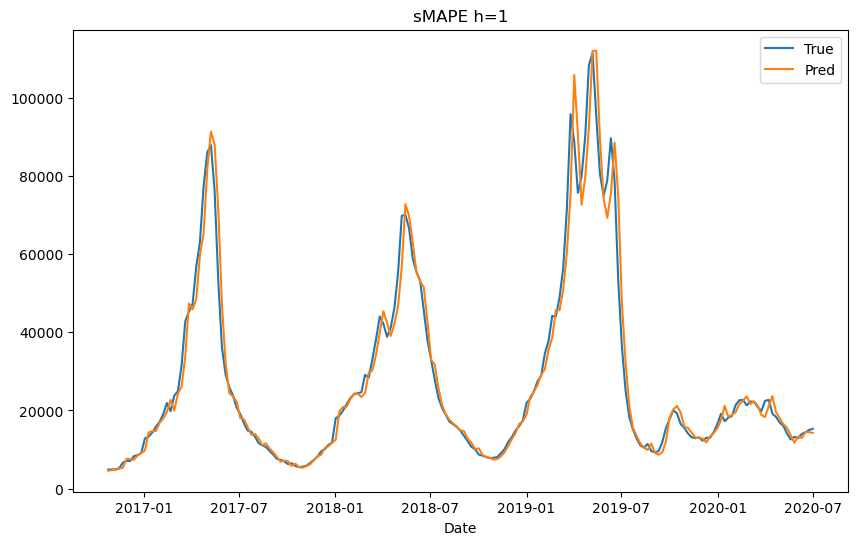

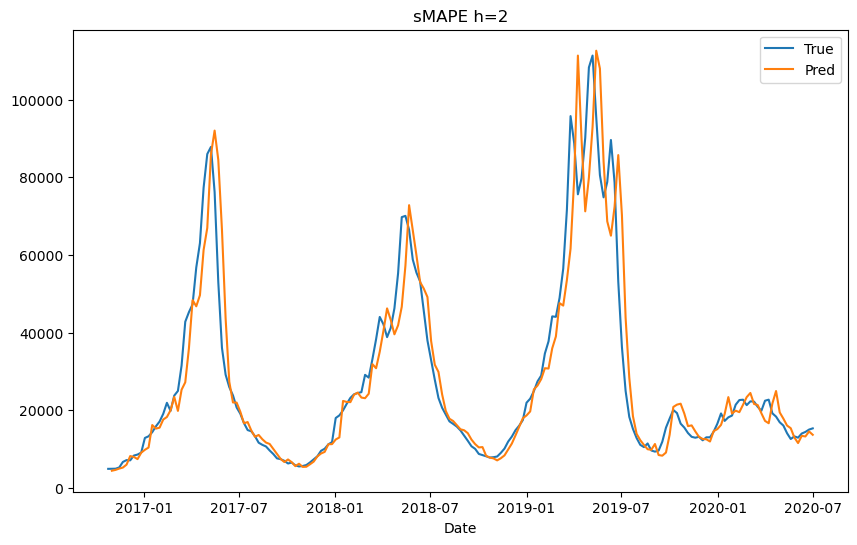

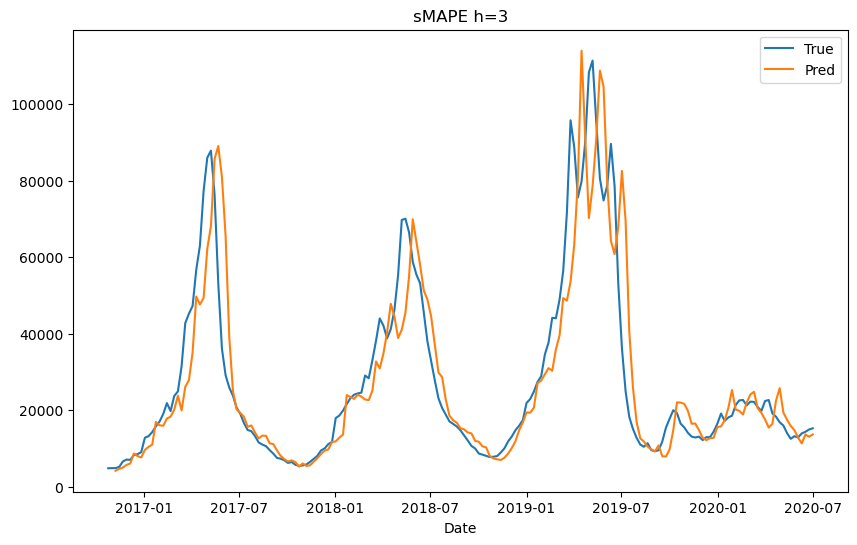

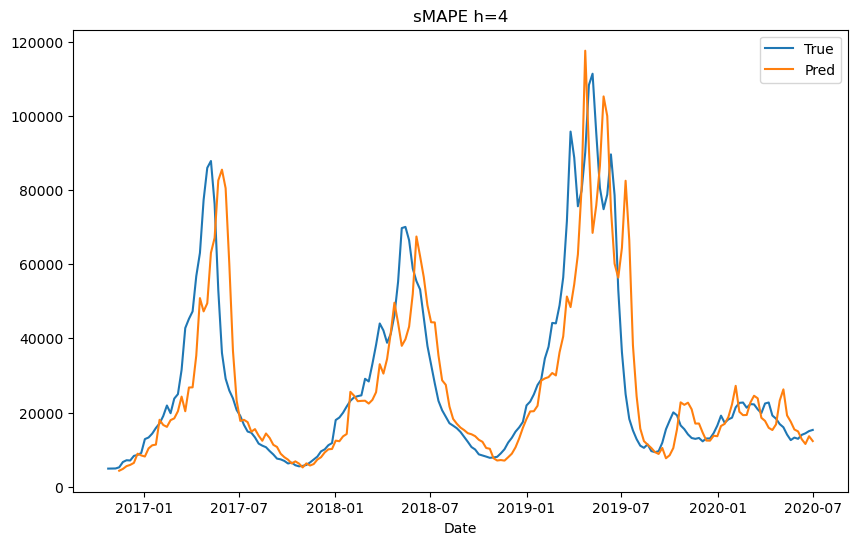

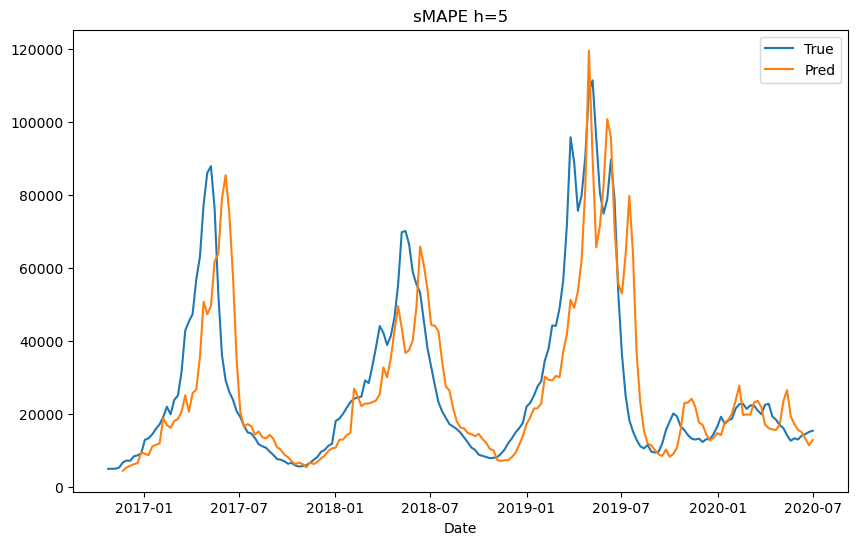

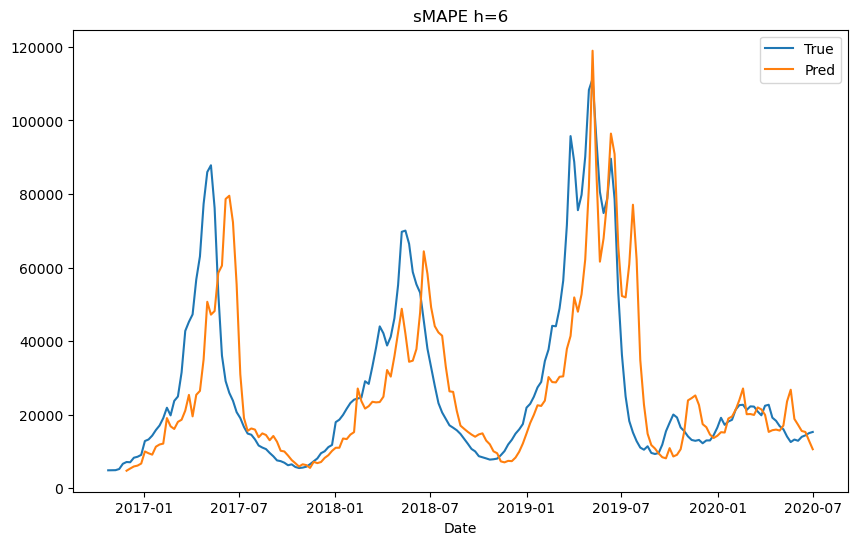

(188,) (188,)
sMAPE           ILITOTAL
Average  22.636761
MAE             ILITOTAL
Average  6963.882646
++++++++++++++++++++++++++++++++++++++++++++


In [21]:
#FOR ILI
file_name = 'national_illness.csv'
read_data = pd.read_csv(file_name)
n_train = round(len(read_data) * 0.8)
n_test = len(read_data) - n_train
y_list = ["ILITOTAL"]
# y = 'ILITOTAL'
data = "ILI"
m = 13
p = 3
d = 0
q = 3
ps = 3
ds = 0
qs = 1
trend = 'n'
for y in y_list:
    print(y)
    for horizons in [6]:
        print("horizons: ", horizons)
        temp_results = run_model(n_train,n_test,y,horizons,file_name,m,p,d,q,ps,ds,qs,trend)
        df_final_forecast = predict_table(n_test, temp_results,horizons)
        print(df_final_forecast)
        df_smape_results = smape_results(df_final_forecast, y,file_name)
        print("sMAPE {}".format(df_smape_results.tail(1)))
        df_mae_results = mae_results(df_final_forecast, y,file_name)
        print("MAE {}".format(df_mae_results.tail(1)))
        df_normmae_results = normmae_results(df_final_forecast, y,file_name)
        # print("normMAE {}".format(df_normmae_results.tail(1)))
        print("===========================")
    print("++++++++++++++++++++++++++++++++++++++++++++")